In [109]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
import matplotlib as mpl
import matplotlib.pyplot as plt
from tifffile import imread

In [126]:
import anndata
adata_exp0 = anndata.read_h5ad('C:/Users/mdichgan/Documents/Helmholtz/send_to_Jakob/spatial/counts_CPc_exp0_BA28.h5ad')
adata_exp0

AnnData object with n_obs × n_vars = 23282 × 284
    obs: 'cell_id', 'ct_majority', 'ct_majority_cert', 'celltype', 'n_counts', 'n_genes', 'area'
    var: 'n_counts', 'n_cells'
    uns: 'log1p', 'pct_noise', 'spots'
    layers: 'lognorm', 'norm', 'raw', 'raw_counts'

In [130]:
def negative_marker_mask(adata_sp: AnnData, key: str='celltype'):
    # Set threshold parameters
    min_number_cells=10 # minimum number of cells belonging to a cluster to consider it in the analysis
    max_ratio_cells=0.005 # maximum ratio of cells expressing a marker to call it a negative marker gene-ct pair
    
    #toarray Schritt notwendig?

    # Filter cell types by minimum number of cells
    celltype_count_sp = adata_sp.obs[key].value_counts()
    ct_filter = (celltype_count_sp >= min_number_cells)
    celltypes = celltype_count_sp.loc[ct_filter].index.tolist()

    #too few celltypes notwendig?

    # Filter cells to eligible cell types
    adata_sp = adata_sp[adata_sp.obs[key].isin(celltypes)]

    # Get ratio of positive cells per cell type
    pos_exp_sp = pd.DataFrame(adata_sp.X > 0,columns=adata_sp.var_names)           #oder mit .layers["raw"], wieso?
    pos_exp_sp['celltype'] = list(adata_sp.obs[key])
    ratio_celltype_sp = pos_exp_sp.groupby('celltype').mean()
    # Get gene-cell type pairs with negative marker expression
    neg_marker_mask = np.array(ratio_celltype_sp < max_ratio_cells)      #oder muss man mit ratio_celltype_sp? wenn ja, wieso?
    genes = adata_sp.var_names
    
    neg_marker_mask = pd.DataFrame(neg_marker_mask, columns = genes, index = ratio_celltype_sp.index)
    neg_marker_dict = {celltype: [] for celltype in celltypes}

    for celltype, row in neg_marker_mask.iterrows():
        for gene in genes:
            if row[gene]:
                neg_marker_dict[celltype].append(gene)

    return neg_marker_dict


In [131]:
#test negative_marker_mask
dict_exp0 = negative_marker_mask(adata_exp0, key='celltype')

In [127]:
def get_boolean_column(spots: pd.DataFrame, adata_sp: AnnData
      ):

    """add column in_correct_celltype.

       in_correct_celltype is TRUE, if gene is in_correct_celltype, else FALSE. 

       Parameters
       ----------
       spots : str
            path to csv-file containing spots-information with columns: gene, x, y, celltype
       
       Returns
       ----------
       pandas DataFrame

    """

    df = spots
   #  df = pd.read_csv(spots)
    neg_marker_dict = negative_marker_mask(adata_sp)

   #  df["in_correct_celltype"] = False

    list_of_keys = list(neg_marker_dict.keys())

    df = df.loc[df["celltype"].isin(list_of_keys)]

    for n in range(df.shape[0]):
        if df.iloc[n]['gene'] in neg_marker_dict[(df.iloc[n]['celltype'])]:
            df['in_correct_celltype'].iloc[n] = True

   #  oder mit list comprehension:  for ct in celltypes:
   #  df.loc[(df["gene"].isin(negative_markers[ct])) & (df["celltype"] == ct)]        
    
   #  df = df.assign(in_correct_celltype= np.random.choice([True,False], len(df.index)))
    return df

In [ ]:
#test get_boolean_column
spots = pd.read_csv('C:/Users/mdichgan/Documents/Helmholtz/test/spots.csv')
df = get_boolean_column(spots)
print(df)
print(df['x'].min(), df['x'].max(), df['y'].min(), df['y'].max())
x_min, x_max, y_min, y_max = df['x'].min(), df['x'].max(), df['y'].min(), df['y'].max()


In [132]:
#test get_boolean_column
df_exp0 = get_boolean_column(adata_exp0.uns['spots'],adata_sp=adata_exp0)
df_exp0.head()
print(df_exp0['x'].min(), df_exp0['x'].max(), df_exp0['y'].min(), df_exp0['y'].max())


In [ ]:
def plot_spots(x_min: int, x_max: int, y_min: int, y_max: int, spots: pd.DataFrame, image: str):
    """plot gene spots
     
       spot is red if entry in 'in_correct_celltype' is FALSE, else blue

       Parameters
       ----------
       x_min: int, x_max: int, y_min: int, y_max: int 
            crop coordinates
       spots: str
            path to csv file containing spots-information with columns: gene, x, y, celltype, in_correct_celltype
       image: str
            path to tif file containing image of dapi stained cell-nuclei
    """
    s_factor = 0.6
    
    fig, ax = plt.subplots()
#   df = get_boolean_column(spots)
    
    x = imread(image)
 
    #x = x[int(x_min):int(x_max),int(y_min):int(y_max)] funktioniert nicht
    
    plot = ax.imshow(x,cmap = "binary_r", origin = 'lower')
    
    ax.scatter(
        df['x'],df['y'],
        s = [s_factor*1 if v else s_factor*5 for v in df["in_correct_celltype"]],
        color = ["cyan" if v else "red" for v in df["in_correct_celltype"]],
    )
    
    ax.axis([x_min, x_max, y_min, y_max ])
    fig.colorbar(plot, ax = ax)

In [ ]:
#test plot_spots
plot_spots(
    x_min, x_max, y_min, y_max, 
    df, 
    'C:/Users/mdichgan/Documents/Helmholtz/test/raw_image.tif'
    )

In [122]:
def wrong_spot_density(spots: pd.DataFrame #, x_min: int, x_max: int, y_min: int, y_max: int
                       ,bins, #smooth: float
                       ):
    # bins mehrere Optionen (int, zwei arrays etc.) -> wie?
    
#      binsint or array_like or [int, int] or [array, array], optional
# The bin specification:

# If int, the number of bins for the two dimensions (nx=ny=bins).

# If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).

# If [int, int], the number of bins in each dimension (nx, ny = bins).

# If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).

# A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.

   

    true_spots = spots.loc[spots['in_correct_celltype'] == True]
    x_t = true_spots['x']
    y_t = true_spots['y']

    H_t, xedges, yedges = np.histogram2d(x_t, y_t, bins = bins)
    # Histogram does not follow Cartesian convention (see Notes),
    # therefore transpose H for visualization purposes.
    H_t = H_t.T

    false_spots = spots.loc[spots['in_correct_celltype'] == False]
    x_f = false_spots['x']
    y_f = false_spots['y']

    H_f, xedges, yedges = np.histogram2d(x_f, y_f, bins = bins)
    # Histogram does not follow Cartesian convention (see Notes),
    # therefore transpose H for visualization purposes.
    H_f = H_f.T

    H = H_f/(H_f + H_t)

    fig = plt.figure()
    ax = fig.add_subplot(title='false spots density')
    plot = plt.imshow(H, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    fig.colorbar(plot)


C:\Users\mdichgan\AppData\Local\Temp\ipykernel_16912\4213165090.py:25: RuntimeWarning: invalid value encountered in divide
  H = H_f/(H_f + H_t)


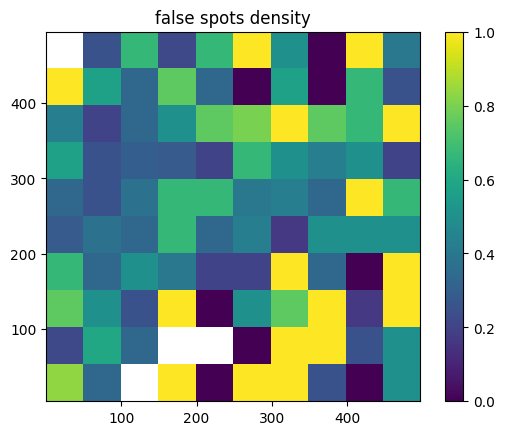

In [125]:
wrong_spot_density(spots=df,bins=[10,10])

# wrong_spot_density(spots=df_exp0,bins=[50,50])         wieso funktioniert es hier nicht? Wieso colorbar bis -0.1!?

